# FlickBike - Distributed Processing (DIP)
---

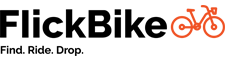

__Voor deze opdracht werken we samen met FlickBike. FlickBike is een aanbieder van deelfietsen. Dat zijn fietsen die voor korte termijn, meestal een enkele rit, gehuurd kunnen worden door abonnees. In het geval van FlickBike mag je een fiets huren en achterlaten waar je maar wilt.__

__Voor deze opdracht zijn er een aantal vraagstukken geformuleerd die we aan de hand van wat analyse proberen te beantwoorden:__
    - Hoe bereken je  de groei van FlickBike? In het bijzonder: hoe voorspel je het aantal verhuurde fietsen op de dagen tussen 10 december 2019 en 31 januari 2020?

    - Welke invloeden verwacht je van, en op welke manier kun je je model gevoelig maken voor?

    - Hoe kan, op basis van data, worden voorspeld waar er tekorten van fietsen dreigen te ontstaan en hoe de fietsen het beste zo kunnen worden verplaatst dat ze zowel over het hele terrein van Schiphol-Oost beschikbaar zijn en tegelijkertijd vooral beschikbaar zijn op plaatsen waar het regelmatig druk is?

    - Hoe kun je berekenen met hoeveel fietsen zou FlickBike minimaal kunnen werken, zodanig dat te verwachten pieken op te vangen zijn?
    

__In deze notebook wordt de eerste vraag beantwoord__

#### Data dictionary

---

- __Account__ = business
- __Bikeid__ = intern gebruik
- __Bikenumber__ = zichtbaar op fietsen (QR-CODE)
- __Date__ = moment van invoering in database
- __Start_time__ = start-tijd van sessie
- __End_time__ = eind-tijd van sessie
- __Start_lat__ = begin locatie latitude
- __Start_lng__ = begin locatie longtitude
- __End_lat__ = einde locatie latitude
- __End_lng__ = einde locatie longtitude



---
- __test.csv__ = fietsverhuur tussen 1-11-2019 en 09-12-2019 # 7657 rows
- __train.csv__ = fietsverhuur voor 1-11-2019. Wordt gebruikt om voorspellingen te maken voor de dagen die hierop volgen # 42720 rows
- __bikes.cvs__ = alle fietsverhuur # 50377 rows
---

#### Import libraries 

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('ignore')

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Data processing
import pandas as pd
import numpy as np
import datetime

# Provides access to some variables
import sys
sys.path.append('/Users/wolfsinem/Distributed-Processing/Bike-Rental-FlickBike')

# Model training / predicting 
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Import external weather data from KNMI
from knmi import weather_temp_HH, weather_temp_DD, weather_wind_DD, weather_PRCP_DD
%matplotlib inline

#### Load data

In [2]:
# Load seperate Train and Test data
train_data = pd.read_csv(("/Users/wolfsinem/flick_data/train.csv"))
test_data = pd.read_csv(("/Users/wolfsinem/flick_data/test.csv"))

# Give train_data different variable 
df = train_data

# Load submission file starting from 1-11-2019 till 31-1-2020
sample_sub = pd.read_csv("/Users/wolfsinem/flick_data/sampleSubmission.csv")
validation_set = pd.read_csv("/Users/wolfsinem/flick_data/sampleSubmission.csv")

# Load holiday files 
national_holidays = pd.read_csv(("/Users/wolfsinem/distributed-processing/bike-rental-flickbike/data/Nationale Feestdagen.csv"))
other_holidays = pd.read_csv(("/Users/wolfsinem/distributed-processing/bike-rental-flickbike/data/Overige Feestdagen.csv"))

#### First look at the train_set dataframe

In [3]:
df.head()

,Unnamed: 0,tripid,userid,bikeid,account,bikenumber,start_time,end_time,start_lat,start_lng,end_lat,end_lng,date
0,1,33838,13452,382,AT,6631000433,2019-01-01 06:46:03,2019-01-01 06:46:03,52.296065,4.787667,52.296200,4.787679,2019-01-01 06:46:00
1,2,33839,13452,812,AT,6631000146,2019-01-01 06:47:39,2019-01-01 06:47:39,52.295938,4.788336,52.295940,4.788557,2019-01-01 06:47:35
2,3,33851,13182,238,AT,6631000443,2019-01-01 14:15:36,2019-01-01 14:15:36,52.307337,4.807633,52.307336,4.807630,2019-01-01 14:15:32
3,4,33852,13182,238,AT,6631000443,2019-01-01 14:33:50,2019-01-01 14:33:50,52.308478,4.809970,52.308537,4.810099,2019-01-01 14:33:46
4,5,33867,12674,787,AI,6631000283,2019-01-01 20:11:05,2019-01-01 20:11:05,52.510340,4.725336,52.508565,4.726276,2019-01-01 20:11:01


In [4]:
df.shape

(42720, 13)

#### Check for missing values

In [5]:
print(df.isnull().sum())
print('---------------')
print(test_data.isnull().sum())
# msno.matrix(df) # visualiseren van missende waarden, maar die zijn er niet

Unnamed: 0    0
tripid        0
userid        0
bikeid        0
account       0
bikenumber    0
start_time    0
end_time      0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
date          0
dtype: int64
---------------
Unnamed: 0    0
tripid        0
userid        0
bikeid        0
account       0
bikenumber    0
start_time    0
end_time      0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
date          0
dtype: int64


#### Correlation dataframe before changing anything

---

Er is een sterke correlatie te zien bij de kolommen __start_lat / end_lat__ en __start_lng / end_lng__ maar ik verwacht niet dat we met deze kolommen het fietsverhuur kunnen voorspellen, ik zal hier daarom niet, voor nu, verder op ingaan. Je kunt hiermee wel checken in welke gebieden er de meeste fietsen worden gebruikt om andere vraagstukken van het project te beantwoorden, zoals het opvangen van pieken en voorkomen van tekorten.

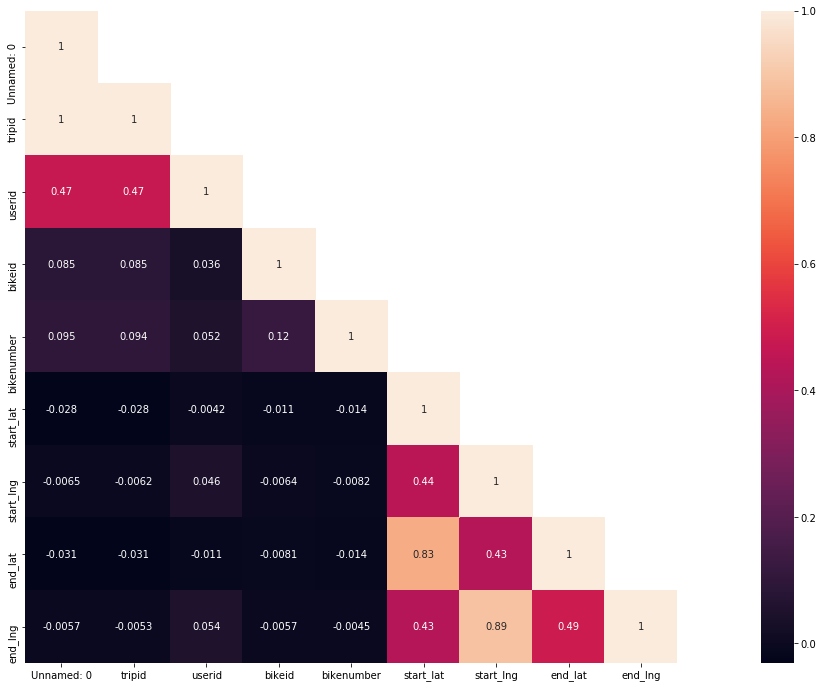

In [6]:
fig=plt.gcf()
fig.set_size_inches(30,12)

df_correlation = df[:].corr()

mask = np.array(df_correlation)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(data=df_correlation,mask=mask,square=True,annot=True,cbar=True)
plt.show()

#### Convert to datetime

In [7]:
# Convert column date to datetime
df['date'] = pd.to_datetime(df['date'])

# Remove time of datetime variable 
df['fixed_date'] = pd.to_datetime(df['date']).dt.date 

# Convert column date of test_data
test_data["date"] = pd.to_datetime(test_data["date"], format="%Y-%m-%d %H:%M:%S")

#### Influence of day of week
---

Aan de hand van deze functie en plot wordt er gekeken of een dag in de week invloed heeft op het aantal fietsen wat wordt verhuurd. 
    - 0 = maandag
    - 1 = dinsdag
    - 2 = woensdag
    - 3 = donderdag
    - 4 = vrijdag
    - 6 = zaterdag
    - 7 = zondag
    
*(Python start met 0 = maandag, JAVA 0 = zondag)*

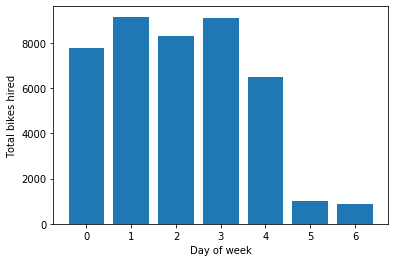

In [8]:
day_of_week = df['date'].apply(lambda time: time.dayofweek).value_counts()

x = day_of_week.index
y = day_of_week.values
plt.bar(x,y)
plt.xlabel('Day of week')
plt.ylabel('Total bikes hired')
plt.show()

De plot laat heel duidelijk zien dat er op __maandag__ t/m __vrijdag__ veel gebruik wordt gemaakt van de FlickBikes. In het weekend zie je dat dit aantal fors afneemt en mensen zelden gebruik maken van een huur-fiets.

#### Influence of hour of day

--- 

Zoals er voor het openbaarvervoer ook spitstijden gelden zullen we kijken of hier ook spraken van is voor de FlickBikes.


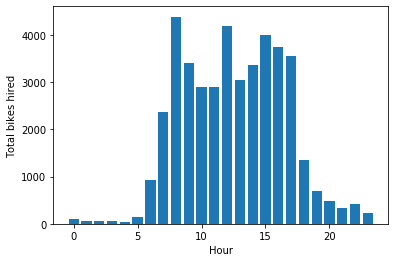

In [9]:
hour_in_day = df['date'].apply(lambda time: time.hour).value_counts()

x = hour_in_day.index
y = hour_in_day.values
plt.bar(x,y)
plt.xlabel('Hour')
plt.ylabel('Total bikes hired')
plt.show()

De plot laat zien dat er een soort __klokvormige verdeling__ (zoals we die kennen van de normaal verdeling) is als we kijken naar hoeveel er wordt verhuurd op bepaalde tijden. Om 8 uur in de ochtend is het 't drukst en vanaf de avond om 6 uur neemt het weer af.

#### Influence of month

--- 
Tot slot kijken we ook of maanden invloed hebben op het verhuur. We zouden hiervoor ook extra kolommen kunnen toevoegen zoals __seizoen__:
    - lente
    - zomer
    - herfst
    - winter

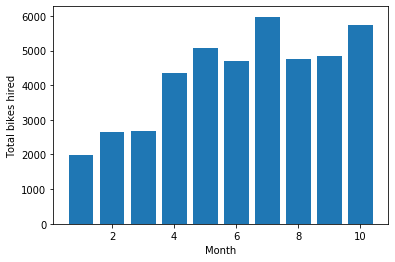

In [10]:
month_of_year = df['date'].apply(lambda time: time.month).value_counts()

x = month_of_year.index
y = month_of_year.values
plt.bar(x,y)
plt.xlabel('Month')
plt.ylabel('Total bikes hired')
plt.show()

#### Add extra columns (Feature Engineering)
---

Dit zijn extra kolommen die we toevoegen aan de dataframe omdat er aan de hand van de visualisatie blijkt dat er wel degelijk een sterke correlatie is voor:
    - maanden in het jaar
    - dagen in de week
    - uren op een dag



In [11]:
df['month'] = df['date'].apply(lambda time: time.month) 
# df['hour'] = df['date'].apply(lambda time: time.hour)
df['day'] = df['date'].apply(lambda time: time.dayofweek)

#### Add season column

*I couldn't find an easier way to add a column 'season' out of the column 'date' so thats why I used this function which works perfectly fine*

In [12]:
"""
Function returns type of season from 1 to 4 based on column 'month'

1 = winter
2 = spring
3 = summer
4 = fall

"""
def getSeason(dfc): # dfc = dataframe column 
    seasons = []
    for month in dfc.values:
        if (month > 11 or month <= 3):
            seasons.append(1)
        elif (month == 4 or month == 5):   
            seasons.append(2)
        elif (month >=6 and month <= 9):
               seasons.append(3)    
        else:
               seasons.append(4)    
    return(seasons)

In [13]:
df['season'] = getSeason(df['month'])

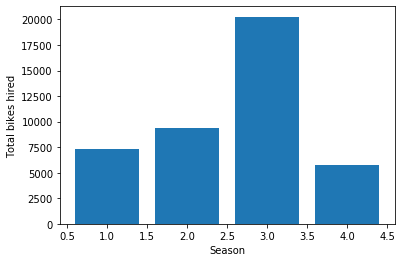

In [14]:
season_values = df['season'].value_counts()

x = season_values.index
y = season_values.values
plt.bar(x,y)
plt.xlabel('Season')
plt.ylabel('Total bikes hired')
plt.show()

In de plot hierboven zien we dat op __punt 3__ van de x-as veruit de meeste fietsen zijn verhuurd. Als we kijken naar de functie getSeason zien we dat dit in het __zomer seizoen__ is, wat eigenlijk ook wel logisch is.

#### Visualize rental count

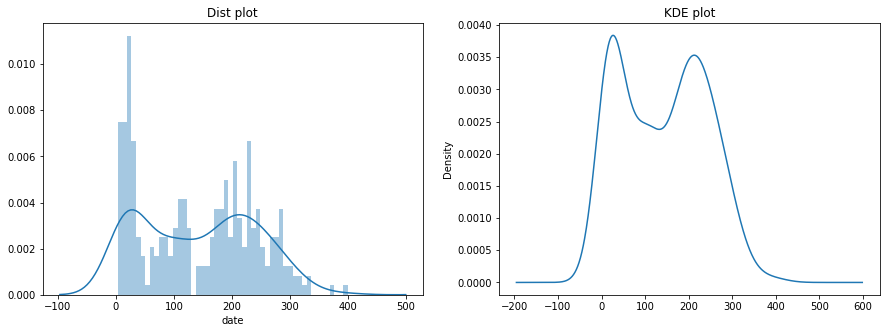

In [15]:
# Variable consists of index(date) and values(amount)
group_date = df['date'].groupby(df.date.dt.floor('d')).count()

# Distribution of target variable
_ , ax = plt.subplots(1,2, figsize=(15,5)) # 1 row 2 column subplot 

sns.distplot(group_date, bins=50, ax=ax[0]) # dependent variable distribution plot with 50 bins
ax[0].set_title('Dist plot')

ax[1] = group_date.plot(kind='kde') # dependent variable kernel density estimate* plot 
ax[1].set_title('KDE plot')
plt.show()
# sns.barplot(group_date.index, group_date.values, alpha=0.8)

KDE* = Kernel Density Estimate 

*"is in some senses an algorithm which takes the mixture-of-Gaussians idea to its logical extreme"*

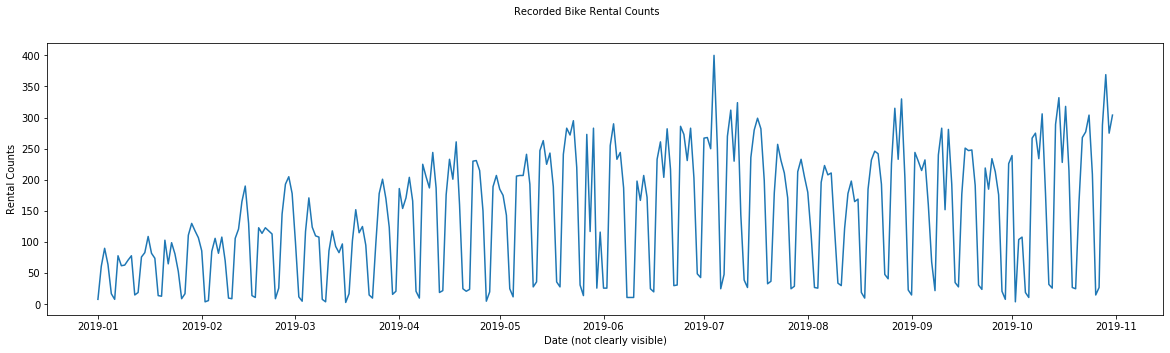

In [16]:
# Visualize count per date
fig, ax = plt.subplots(1, figsize=(20,5))
ax.plot(group_date)

ax.set_xlabel('Date (not clearly visible)', fontsize = 10)
ax.set_ylabel('Rental Counts', fontsize = 10)
fig.suptitle('Recorded Bike Rental Counts', fontsize = 10)

plt.show()

In [17]:
group_date

date
2019-01-01      8
2019-01-02     61
2019-01-03     90
2019-01-04     64
2019-01-05     17
             ... 
2019-10-27     27
2019-10-28    288
2019-10-29    369
2019-10-30    275
2019-10-31    304
Name: date, Length: 303, dtype: int64

#### Add external data for holidays (2019)

---
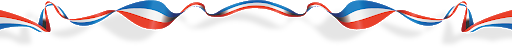
Hiervoor zijn de Nederlandse nationale feestagen en overige feestdagen gedownload en gebruikt om te kijken of deze "__speciale dagen__" invloed hebben op het fietsverhuur.

Bron: https://kalender-nederland.nl/feestdagen-2019/ 

In [18]:
all_holidays = pd.concat([national_holidays,other_holidays]).reset_index(drop=True)
all_holidays['Datum'] = pd.to_datetime(all_holidays['Datum'])
all_holidays['Datum'] = all_holidays['Datum'].dt.date

In [19]:
all_holidays.tail()

,Feestdag,Datum
18,Prinsjesdag 2019,2019-09-17
19,Sint Maarten 2019,2019-11-11
20,Black Friday 2019,2019-11-29
21,Sinterklaas 2019,2019-12-05
22,Oudejaarsdag 2019,2019-12-31


#### Merge holidays with original dataset 'df'
---

Door dit te doen kunnen we nakijken hoeveel fietsen er werden verhuurd op een feestdag. Zoals we in de uitkomsten onderin kunnen zien zijn er alleen __1208__ (2.8%) fietsen verhuurd op een feestdag, in tegenstelling tot __41511__ (97%) fietsen op een 'normale' dag.

In [20]:
check_holiday = df['date'].dt.date.isin(all_holidays.Datum)
check_holiday.value_counts(normalize=True)

False    0.971699
True     0.028301
Name: date, dtype: float64

In [21]:
df['holiday'] = check_holiday

#### Add Dutch weather data from KNMI 

---
Er zijn functies geschreven in de file *knmi.py* om wat variabelen op te halen.

Bron: https://www.knmi.nl/kennis-en-datacentrum/achtergrond/data-ophalen-vanuit-een-script

*Later kwam ik er echter achter dat er ook een makkelijke manier is om direct de data te houden met kolommen die je zelf wilt meenemen https://projects.knmi.nl/klimatologie/uurgegevens/selectie.cgi*

#### Temperature

In [22]:
# df_temp = weather_temp_DD()

# df_temp.reset_index(inplace=True) # reset index
# df_temp.rename(columns={'YYYYMMDD': 'fixed_date'},inplace=True) # rename column YYYYMMDD to fixed_date
# df_temp['fixed_date'] = pd.to_datetime(df_temp['fixed_date']).dt.date
# df_temp.drop(columns=['STN'],inplace=True)

# # Pas de getallen aan zodat we ermee kunnen werken
# df_temp['TG'] = df_temp['TG'] * 0.1
# df_temp['TN'] = df_temp['TN'] * 0.1
# df_temp['TX'] = df_temp['TX'] * 0.1
# df_temp['TXH'] = df_temp['TXH'] * 0.1

# df = pd.merge(df, df_temp, on=['fixed_date'])

# df_temp.head()

#### Wind

In [23]:
# df_wind = weather_wind_DD()

# df_wind.reset_index(inplace=True)

# df_wind.rename(columns={'YYYYMMDD': 'fixed_date'},inplace=True) # rename column YYYYMMDD to fixed_date
# df_wind['fixed_date'] = pd.to_datetime(df_wind['fixed_date']).dt.date
# df_wind.drop(columns=['STN'],inplace=True)

# df_wind['FHVEC'] = df_wind['FHVEC'] * 0.1
# df_wind['FG'] = df_wind['FG'] * 0.1
# df_wind['FHX'] = df_wind['FHX'] * 0.1
# df_wind['FHN'] = df_wind['FHN'] * 0.1
# df_wind['FXX'] = df_wind['FXX'] * 0.1

# df = pd.merge(df, df_wind, on=['fixed_date'])

# df_wind.head()

#### Rain

In [24]:
# df_rain = weather_PRCP_DD()

# df_rain.reset_index(inplace=True)

# df_rain.rename(columns={'YYYYMMDD': 'fixed_date'},inplace=True) # rename column YYYYMMDD to fixed_date
# df_rain['fixed_date'] = pd.to_datetime(df_rain['fixed_date']).dt.date
# df_rain.drop(columns=['STN'],inplace=True)

# df_rain['DR'] = df_rain['DR'] * 0.1
# df_rain['RH'] = df_rain['RH'] * 0.1
# df_rain['RHX'] = df_rain['RHX'] * 0.1
# df_rain['EV24'] = df_rain['EV24'] * 0.1

# df = pd.merge(df, df_rain, on=['fixed_date'])

# df_rain.head()

#### Seperate dataframe with all of the weather variables combined

In [25]:
# df_temp = pd.merge(df_temp,df_wind, on=['fixed_date'])
# df_temp = pd.merge(df_temp,df_rain, on=['fixed_date'])

#### Add count column which tells how many bikes were hired on that date

In [26]:
count = pd.DataFrame(data=group_date).rename_axis('fixed_date').reset_index()
count.rename(columns={'date': 'count'},inplace=True)
count['fixed_date'] = pd.to_datetime(count['fixed_date']).dt.date

In [27]:
df = pd.merge(df,count, on=['fixed_date'])

---

### Preparing Training set (df_final)

---

In [28]:
# Dataframe columns before preperation
df.columns

Index(['Unnamed: 0', 'tripid', 'userid', 'bikeid', 'account', 'bikenumber',
       'start_time', 'end_time', 'start_lat', 'start_lng', 'end_lat',
       'end_lng', 'date', 'fixed_date', 'month', 'day', 'season', 'holiday',
       'count'],
      dtype='object')

In [29]:
df_final = df.drop(columns=['Unnamed: 0','tripid','userid','bikeid','account','bikenumber','start_lat','start_lng','end_lat','end_lng','start_time','end_time','date'])
df_final = df_final.drop_duplicates(subset='fixed_date').reset_index(drop=True)

# Getting dummies for column 'holiday'
df_final['holiday'] = df_final['holiday'].astype(int)
holiday_dum = pd.get_dummies(df_final['holiday'],prefix='holiday')
df_final = pd.concat([df_final,holiday_dum],axis=1)
df_final = df_final.drop(columns=['holiday'])

In [30]:
df_final.head()

,fixed_date,month,day,season,count,holiday_0,holiday_1
0,2019-01-01,1,1,1,8,0,1
1,2019-01-02,1,2,1,61,1,0
2,2019-01-03,1,3,1,90,1,0
3,2019-01-04,1,4,1,64,1,0
4,2019-01-05,1,5,1,17,1,0


In [31]:
df_final.shape

(303, 7)

---

### Preparing Test set (test_data)

Going through exactly the same process as for the train set

---

In [32]:
test_data['date'] = pd.to_datetime(df['date'])
test_data['fixed_date'] = pd.to_datetime(test_data['date']).dt.date 

test_data['month'] = test_data['date'].apply(lambda time: time.month) 
# test_data['hour'] = test_data['date'].apply(lambda time: time.hour)
test_data['day'] = test_data['date'].apply(lambda time: time.dayofweek)

test_data['season'] = getSeason(test_data['month'])
season_values = test_data['season'].value_counts()

check_holiday = test_data['date'].dt.date.isin(all_holidays.Datum)
test_data['holiday'] = check_holiday

test_data = test_data.drop(columns=['Unnamed: 0','tripid','userid','bikeid','account','bikenumber','start_lat','start_lng','end_lat','end_lng','start_time','end_time','date'])
test_data = test_data.drop_duplicates(subset='fixed_date').reset_index(drop=True)

test_data['holiday'] = test_data['holiday'].astype(int)
holiday_dum = pd.get_dummies(test_data['holiday'],prefix='holiday')
test_data = pd.concat([test_data,holiday_dum],axis=1)
test_data = test_data.drop(columns=['holiday'])

In [33]:
test_data.head()

,fixed_date,month,day,season,holiday_0,holiday_1
0,2019-01-01,1,1,1,0,1
1,2019-01-02,1,2,1,1,0
2,2019-01-03,1,3,1,1,0
3,2019-01-04,1,4,1,1,0
4,2019-01-05,1,5,1,1,0


In [34]:
test_data.shape

(93, 6)

---

### Preparing validation set in which we will store the predicted values

In [35]:
validation_set['id'] = pd.to_datetime(validation_set['id'], format="%Y%m%d")

validation_set['month'] = validation_set['id'].apply(lambda time: time.month) 
validation_set['day'] = validation_set['id'].apply(lambda time: time.dayofweek)

validation_set['season'] = getSeason(validation_set['month'])

check_holiday = validation_set['id'].dt.date.isin(all_holidays.Datum)
validation_set['holiday'] = check_holiday
validation_set['holiday'] = validation_set['holiday'].astype(int)
holiday_dum = pd.get_dummies(validation_set['holiday'],prefix='holiday')
validation_set = pd.concat([validation_set,holiday_dum],axis=1)
validation_set = validation_set.drop(columns=['holiday','Predicted'])

In [36]:
validation_set = validation_set.rename(columns={'id': 'fixed_date'})

In [37]:
validation_set

,fixed_date,month,day,season,holiday_0,holiday_1
0,2019-11-01,11,4,4,1,0
1,2019-11-02,11,5,4,1,0
2,2019-11-03,11,6,4,1,0
3,2019-11-04,11,0,4,1,0
4,2019-11-05,11,1,4,1,0
...,...,...,...,...,...,...
87,2020-01-27,1,0,1,1,0
88,2020-01-28,1,1,1,1,0
89,2020-01-29,1,2,1,1,0
90,2020-01-30,1,3,1,1,0


In [38]:
validation_set.shape

(92, 6)

### Model training

#### Split into train/test

---

In [39]:
train_X = df_final.drop(columns=['fixed_date','count']) # Independent variables
train_y = df_final[['count']] # Target variable

print(train_X.shape)
print(train_y.shape)

(303, 5)
(303, 1)


In [40]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, test_size = 0.25, random_state = 42)

#### Different Machine Learning Models

---

In [41]:
# All the different models tested so we can see which one is scoring better
models = [RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(),DecisionTreeClassifier()]
model_names = ['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor','DecisionTreeClassifier']

# Save the outcome in new variables
rmse = [] # Calculation the root mean squared error
model_score = {} # Store model name and corresponding score

# For loop to train each model
for model in range (len(models)):
    clf = models[model]
    clf.fit(x_train, y_train)
    test_pred = clf.predict(x_test)
    rmse.append(np.sqrt(mean_squared_error(test_pred, y_test)))
model_score = {'Model':model_names,'RMSE':rmse}   

In [42]:
rmse_frame = pd.DataFrame(model_score)
rmse_frame

,Model,RMSE
0,RandomForestRegressor,41.577957
1,AdaBoostRegressor,40.064189
2,BaggingRegressor,40.133838
3,SVR,82.416851
4,KNeighborsRegressor,43.250221
5,DecisionTreeClassifier,62.186900


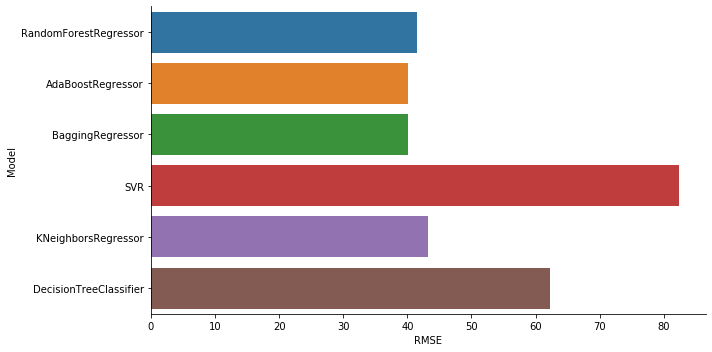

In [43]:
sns.factorplot(y='Model',x='RMSE',data=rmse_frame,kind='bar',size=5,aspect=2)
plt.show()

#### Finding optimal parameters for RandomForestRegressor so we can make our prediction

I've seen the best results on Kaggle using the RandomForestRegressor

In [44]:
no_of_test = [500]
params_dict = {'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf = GridSearchCV(estimator = RandomForestRegressor(),param_grid=params_dict,scoring = 'neg_mean_squared_log_error')
clf_rf.fit(x_train, y_train)
pred = clf_rf.predict(x_test)
print((np.sqrt(mean_squared_error(pred, y_test))))

40.925019140679204


#### Visualize predicted values

In [45]:
def prediction_plot(real_val,predicted_val):
    plt.figure(figsize=(20,10))
    plt.plot(range(len(real_val)), real_val,'-')
    plt.plot(range(len(predicted_val)),predicted_val,':')
    
    plt.ylabel('Amount of bikes hired')
    plt.xlabel('Date')
    plt.title('Visualize Predicted Values')
    plt.legend(["Real Values", "Predicted Values"])
    plt.plot()

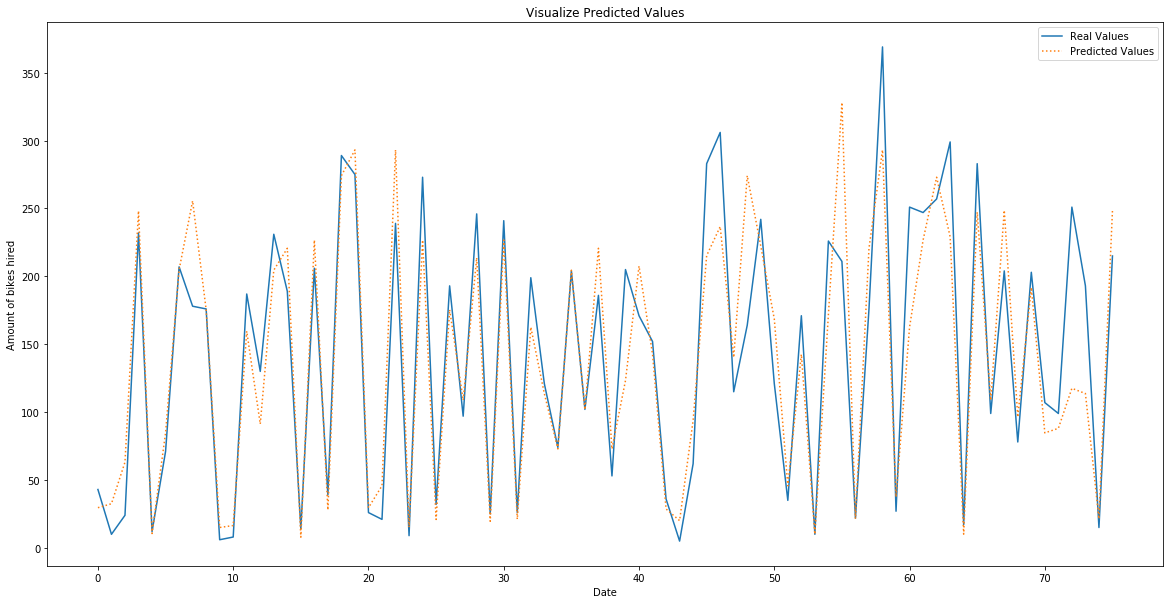

In [46]:
prediction_plot(y_test,pred)

# Submission file

Data from 11-01-2019 to 31-01-2020 (92 days)

---

#### After choosing the best model, make predictions with it for the upcoming days and store predicted values in Submission Dataframe 

In [47]:
forecasting_values = clf_rf.predict(validation_set.drop(columns=['fixed_date']))

sample_sub['Predicted'] = forecasting_values
# sample_sub.to_csv('RandomForestRegressor_5.csv',index=False)

#### AdaBoostRegressor scored best so we might as wel submit this one to Kaggle so see the result

In [48]:
abreg = AdaBoostRegressor()

# We are again checking with GridSearchCV which parameters combined come with the best score
params = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01, 0.05, 0.1, 0.5],
 'loss' : ['linear', 'square', 'exponential']
 }

gridsearch=GridSearchCV(abreg, params, cv=5, return_train_score=True)
gridsearch.fit(x_train, y_train)
GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, 
       loss='linear', n_estimators=50, random_state=None),iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100], 
                   'learning_rate': [0.01, 0.05, 0.1, 0.5], 
                   'loss': ['linear', 'square', 'exponential']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

best_estim=gridsearch.best_estimator_
print(best_estim)

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
                  n_estimators=100, random_state=None)


In [49]:
best_estim.fit(x_train, y_train)
forecasting_values = clf_rf.predict(validation_set.drop(columns=['fixed_date']))

In [50]:
sample_sub['Predicted'] = forecasting_values
# sample_sub.to_csv('AdaBoostRegressor.csv',index=False)

#### After submitting AdaBoostRegressor I've noticed the RandomForestRegressor still doing beter even tho Ada had a lower RMSE score with the training set

In [51]:
model = ['DecisionTreeClassifier', 'RandomForestRegressor', 'AdaBoostRegressor']
kaggle_score = [213.87069,71.86202,71.88419]

kaggle_scores = {'Model':model,'Score':kaggle_score} 
kaggle_df = pd.DataFrame(kaggle_scores)
kaggle_df

,Model,Score
0,DecisionTreeClassifier,213.87069
1,RandomForestRegressor,71.86202
2,AdaBoostRegressor,71.88419
